In [109]:
import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import plotly
import pandas as pd
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.express as px
import xgboost as xgb
import scipy
from scipy.stats import normaltest
import seaborn as sns
import sklearn
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error,  mean_absolute_percentage_error, r2_score
#from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import linear_model
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import sys

import time
#%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

In [110]:
#Chargement des données nettoyées
data = pd.read_csv("df_cleaned.csv")
data.head()

,Unnamed: 0,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),BuildingAge,ParkingRatio,BuildingRatio,FloorsRatio,BuildingsRatio,LargestUseTypeRatio,SecondLargestUseTypeRatio,ThirdLargestUseTypeRatio,NumberOfAllUseTypes,distance_from_center,TotalGHGEmissionsLog,SiteEnergyUse(kBtu)Log
0,0,NonResidential,Hotel,Mayflower park hotel,DOWNTOWN,Hotel,nouse,nouse,60.0,1,1,1,96,0.0000,1.0000,7369.5000,88434.0,1.0000,0.0000,0.0000,5,0.804213,2.399639,6.858920
1,1,NonResidential,Hotel,Paramount Hotel,DOWNTOWN,Hotel,Parking,Restaurant,61.0,0,1,1,27,0.1455,0.8545,9415.0909,103566.0,0.8099,0.1455,0.0446,26,0.788419,2.472552,6.923655
2,2,NonResidential,Hotel,5673-The Westin Seattle,DOWNTOWN,Hotel,nouse,nouse,43.0,1,1,1,54,0.2057,0.7943,23319.7561,956110.0,0.7912,0.0000,0.0000,5,0.973609,3.320204,7.860859
3,3,NonResidential,Hotel,HOTEL MAX,DOWNTOWN,Hotel,nouse,nouse,56.0,1,1,1,97,0.0000,1.0000,6132.0000,61320.0,1.0000,0.0000,0.0000,5,0.946869,2.458532,6.832163
4,4,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),DOWNTOWN,Hotel,Parking,Swimming Pool,75.0,0,1,1,43,0.3531,0.6469,9754.4444,175580.0,0.7031,0.3873,0.0000,29,1.052598,2.704159,7.151450


In [111]:
data.describe()

,Unnamed: 0,ENERGYSTARScore,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),BuildingAge,ParkingRatio,BuildingRatio,FloorsRatio,BuildingsRatio,LargestUseTypeRatio,SecondLargestUseTypeRatio,ThirdLargestUseTypeRatio,NumberOfAllUseTypes,distance_from_center,TotalGHGEmissionsLog,SiteEnergyUse(kBtu)Log
count,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1.626000e+03,1.626000e+03,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000
mean,814.182042,67.028905,0.070111,0.999385,0.722632,60.950800,0.062398,0.937602,3.778965e+04,1.078949e+05,0.868984,0.124420,0.022127,25.178352,4.535414,1.750139,6.488809
std,470.786882,23.252376,0.255412,0.024799,0.447837,32.662677,0.141371,0.141371,1.254987e+05,1.839960e+05,0.307443,0.171986,0.062418,19.705841,3.556382,0.621258,0.560670
min,0.000000,1.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.105000,3.230769e+03,4.300000e+03,0.186500,0.000000,0.000000,5.000000,0.026614,0.146128,4.756896
25%,407.250000,62.000000,0.000000,1.000000,0.000000,34.000000,0.000000,1.000000,1.330006e+04,2.877000e+04,0.691025,0.000000,0.000000,12.000000,1.403120,1.340642,6.103355
50%,814.500000,71.000000,0.000000,1.000000,1.000000,57.000000,0.000000,1.000000,2.282447e+04,4.764400e+04,0.960950,0.000000,0.000000,20.000000,3.709357,1.713322,6.417573
75%,1220.750000,81.000000,0.000000,1.000000,1.000000,93.000000,0.000000,1.000000,3.796950e+04,1.014602e+05,1.000000,0.238875,0.000000,32.750000,6.828526,2.164442,6.844601
max,1630.000000,100.000000,1.000000,1.000000,1.000000,123.000000,0.895000,1.000000,4.660078e+06,2.200000e+06,6.426800,1.452100,0.929100,190.000000,14.241947,4.227166,8.941474


In [112]:
if 'Unnamed: 0' in data.columns:
    data.drop('Unnamed: 0', axis=1, inplace=True)

In [113]:
data.dtypes

BuildingType                     object
PrimaryPropertyType              object
PropertyName                     object
Neighborhood                     object
LargestPropertyUseType           object
SecondLargestPropertyUseType     object
ThirdLargestPropertyUseType      object
ENERGYSTARScore                 float64
SteamUse(kBtu)                    int64
Electricity(kBtu)                 int64
NaturalGas(kBtu)                  int64
BuildingAge                       int64
ParkingRatio                    float64
BuildingRatio                   float64
FloorsRatio                     float64
BuildingsRatio                  float64
LargestUseTypeRatio             float64
SecondLargestUseTypeRatio       float64
ThirdLargestUseTypeRatio        float64
NumberOfAllUseTypes               int64
distance_from_center            float64
TotalGHGEmissionsLog            float64
SiteEnergyUse(kBtu)Log          float64
dtype: object

Nous avons encore une variable d'identification en notre possession, qui était utile lors de l'analyse exploratoire. Cependant, cette variable n'est plus nécessaire pour les étapes suivantes.

In [114]:
data.drop("PropertyName" , axis = 1, inplace= True)
data.drop("BuildingType" , axis = 1, inplace= True)

### Dataset pour l'étude de l'Energy Star

Divisons le score EnergyStar de notre ensemble de données. Nous le réexaminerons après avoir terminé l'évaluation de nos modèles.

In [115]:
data_ES = data

In [116]:
data_ES.dtypes

PrimaryPropertyType              object
Neighborhood                     object
LargestPropertyUseType           object
SecondLargestPropertyUseType     object
ThirdLargestPropertyUseType      object
ENERGYSTARScore                 float64
SteamUse(kBtu)                    int64
Electricity(kBtu)                 int64
NaturalGas(kBtu)                  int64
BuildingAge                       int64
ParkingRatio                    float64
BuildingRatio                   float64
FloorsRatio                     float64
BuildingsRatio                  float64
LargestUseTypeRatio             float64
SecondLargestUseTypeRatio       float64
ThirdLargestUseTypeRatio        float64
NumberOfAllUseTypes               int64
distance_from_center            float64
TotalGHGEmissionsLog            float64
SiteEnergyUse(kBtu)Log          float64
dtype: object

In [117]:
categorical_ES = data_ES.select_dtypes(exclude = "number").columns.tolist()
numerical_ES = data_ES.select_dtypes(include = "number").columns.tolist()
numerical_ES.remove("SiteEnergyUse(kBtu)Log")
numerical_ES.remove("TotalGHGEmissionsLog")

### Séparation en train et test set

In [119]:
seed= 42

#Target consommation totale en énergie
X_energy_ES_log = data_ES.drop(columns = ["SiteEnergyUse(kBtu)Log", "TotalGHGEmissionsLog"])
y_energy_ES_log = data_ES["SiteEnergyUse(kBtu)Log"]

X_energy_ES_train, X_energy_ES_test, y_energy_ES_train, y_energy_ES_test = train_test_split(X_energy_ES_log, y_energy_ES_log, test_size=0.2, random_state=seed)

#Target émissions de Co2
X_Co2_ES_log = data_ES.drop(columns = [ "TotalGHGEmissionsLog", "SiteEnergyUse(kBtu)Log"])
y_Co2_ES_log = data_ES["TotalGHGEmissionsLog"]

X_Co2_ES_train, X_Co2_ES_test, y_Co2_ES_train, y_Co2_ES_test = train_test_split(X_Co2_ES_log, y_Co2_ES_log, test_size=0.2, random_state=seed)


In [120]:
print("Entrainement pour la consommation d'électrité avec Energy Star:  {} lignes,\n Test: {} lignes.\n".format(X_energy_ES_train.shape[0],
                                                            X_energy_ES_test.shape[0]))

print("Entrainement pour les émissions de Co2 avec Energy Star: {} lignes,\nTest: {} lignes.\n".format(X_Co2_ES_train.shape[0],
                                                            X_Co2_ES_test.shape[0]))

Entrainement pour la consommation d'électrité avec Energy Star:  1300 lignes,
 Test: 326 lignes.

Entrainement pour les émissions de Co2 avec Energy Star: 1300 lignes,
Test: 326 lignes.



### Dataset pour le choix de modèle sans energyscore

In [136]:
data_without_ES = data.drop(columns = "ENERGYSTARScore")

In [137]:
data_without_ES.shape

(1626, 20)

Les variables numériques et catégorielles doivent etre standardisées et encodées. Pour ce faire nous devons les identifier.

In [138]:
categorical = data_without_ES.select_dtypes(exclude = "number").columns.tolist()

numerical = data_without_ES.select_dtypes(include = "number").columns.tolist()

#Suppression des target 
numerical.remove("SiteEnergyUse(kBtu)Log")
numerical.remove("TotalGHGEmissionsLog")

In [139]:
categorical

['PrimaryPropertyType',
 'Neighborhood',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType']

In [140]:
numerical

['SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'BuildingAge',
 'ParkingRatio',
 'BuildingRatio',
 'FloorsRatio',
 'BuildingsRatio',
 'LargestUseTypeRatio',
 'SecondLargestUseTypeRatio',
 'ThirdLargestUseTypeRatio',
 'NumberOfAllUseTypes',
 'distance_from_center']

Séparation en train et test set

In [141]:
#Target consommation totale en énergie
X_energy_log = data_without_ES.drop(columns = ["SiteEnergyUse(kBtu)Log","TotalGHGEmissionsLog"])
y_energy_log = data_without_ES["SiteEnergyUse(kBtu)Log"]

X_energy_train, X_energy_test, y_energy_train, y_energy_test = train_test_split(X_energy_log, y_energy_log, test_size=0.2, random_state=seed)

#Target émissions de Co2
X_Co2_log = data_without_ES.drop(columns = ["TotalGHGEmissionsLog", "SiteEnergyUse(kBtu)Log"])
y_Co2_log = data_without_ES["TotalGHGEmissionsLog"]

X_Co2_train, X_Co2_test, y_Co2_train, y_Co2_test = train_test_split(X_Co2_log, y_Co2_log, test_size=0.2, random_state=seed)

In [142]:
X_energy_log

,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),BuildingAge,ParkingRatio,BuildingRatio,FloorsRatio,BuildingsRatio,LargestUseTypeRatio,SecondLargestUseTypeRatio,ThirdLargestUseTypeRatio,NumberOfAllUseTypes,distance_from_center
0,Hotel,DOWNTOWN,Hotel,nouse,nouse,1,1,1,96,0.0000,1.0000,7369.5000,88434.0,1.0000,0.0000,0.0000,5,0.804213
1,Hotel,DOWNTOWN,Hotel,Parking,Restaurant,0,1,1,27,0.1455,0.8545,9415.0909,103566.0,0.8099,0.1455,0.0446,26,0.788419
2,Hotel,DOWNTOWN,Hotel,nouse,nouse,1,1,1,54,0.2057,0.7943,23319.7561,956110.0,0.7912,0.0000,0.0000,5,0.973609
3,Hotel,DOWNTOWN,Hotel,nouse,nouse,1,1,1,97,0.0000,1.0000,6132.0000,61320.0,1.0000,0.0000,0.0000,5,0.946869
4,Hotel,DOWNTOWN,Hotel,Parking,Swimming Pool,0,1,1,43,0.3531,0.6469,9754.4444,175580.0,0.7031,0.3873,0.0000,29,1.052598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,Office,GREATER DUWAMISH,Office,nouse,nouse,0,1,1,33,0.0000,1.0000,12294.0000,12294.0,1.0000,0.0000,0.0000,6,4.597984
1622,Other,DOWNTOWN,Other - Recreation,nouse,nouse,0,1,1,19,0.0000,1.0000,16000.0000,16000.0,1.0000,0.0000,0.0000,18,1.302619
1623,Other,MAGNOLIA / QUEEN ANNE,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool,0,1,1,49,0.0000,1.0000,13157.0000,13157.0,0.5763,0.4237,0.0000,65,3.880382
1624,Mixed Use Property,GREATER DUWAMISH,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,0,1,1,34,0.0000,1.0000,14101.0000,14101.0,0.4681,0.4610,0.0343,92,8.679071


In [143]:
print("Entrainement pour consommation d'électrité:  {} lignes,\n Test: {} lignes.\n".format(X_energy_train.shape[0],
                                                            X_energy_test.shape[0]))

print("Entrainement pour les émissions de Co2: {} lignes,\nTest: {} lignes.\n".format(X_Co2_train.shape[0],
                                                            X_Co2_test.shape[0]))

Entrainement pour consommation d'électrité:  1300 lignes,
 Test: 326 lignes.

Entrainement pour les émissions de Co2: 1300 lignes,
Test: 326 lignes.



## Standardisation et encodage pour données de tests et d'entrainements

In [144]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import RobustScaler

encoder = TargetEncoder()
scaler = RobustScaler()

### Encodage

In [145]:
X_energy_train[categorical]= encoder.fit_transform(X_energy_train[categorical], y_energy_train)
X_energy_test[categorical]= encoder.transform(X_energy_test[categorical], y_energy_test)


X_Co2_train[categorical]=encoder.fit_transform(X_Co2_train[categorical], y_Co2_train)
X_Co2_test[categorical]=encoder.transform(X_Co2_test[categorical], y_Co2_test)

### Standarisation 

In [146]:
X_energy_train[numerical]= scaler.fit_transform(X_energy_train[numerical])
X_energy_test[numerical]= scaler.transform(X_energy_test[numerical])


X_Co2_train[numerical]=scaler.fit_transform(X_Co2_train[numerical])
X_Co2_test[numerical]=scaler.transform(X_Co2_test[numerical])

In [23]:
X_energy_test

,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),BuildingAge,ParkingRatio,BuildingRatio,FloorsRatio,BuildingsRatio,LargestUseTypeRatio,SecondLargestUseTypeRatio,ThirdLargestUseTypeRatio,NumberOfAllUseTypes,distance_from_center
816,6.307746,6.441617,6.587316,6.366559,6.434230,0.0,0.0,-1.0,-0.412017,0.2620,-0.2620,-0.565769,-0.298274,0.108544,0.000000,0.0000,-0.70,0.278705
1167,6.663803,6.553005,6.669322,6.366559,6.434230,0.0,0.0,-1.0,-0.377682,0.3947,-0.3947,-0.548519,-0.410867,-0.718691,0.000000,0.0000,-0.30,0.615931
1434,6.472017,6.736669,6.587316,6.563246,6.675845,0.0,0.0,-1.0,0.961373,0.0000,0.0000,-0.257420,0.025646,-1.572897,2.043478,0.1079,0.95,-0.456739
1220,6.052725,6.271031,6.067447,6.366559,6.434230,0.0,0.0,0.0,-0.394850,0.0000,0.0000,1.166982,-0.428488,0.108544,0.000000,0.0000,0.30,-0.146222
303,7.119745,6.653944,6.587316,6.366559,6.434230,0.0,0.0,0.0,-0.618026,0.4596,-0.4596,0.475690,0.795777,-1.175890,0.000000,0.0000,-0.70,0.181871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,7.119745,6.736669,6.587316,6.813752,6.434230,0.0,0.0,0.0,-0.171674,0.1575,-0.1575,-0.163743,1.451304,-0.403585,0.679454,0.0000,-0.25,-0.348351
1004,6.307746,6.353301,6.587316,6.366559,6.434230,0.0,0.0,0.0,0.583691,0.0000,0.0000,-0.163743,-0.141396,0.108544,0.000000,0.0000,-0.70,1.649021
887,6.459784,6.736669,6.462832,6.413230,6.675845,0.0,0.0,-1.0,0.394850,0.0000,0.0000,-0.461917,-0.028138,-1.541978,0.979540,0.0806,3.75,-0.525452
898,6.390806,6.552712,6.390806,6.366559,6.434230,0.0,0.0,0.0,0.600858,0.0000,0.0000,0.007277,-0.021625,0.108544,0.000000,0.0000,-0.45,-0.110886


In [24]:
X_Co2_test

,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),BuildingAge,ParkingRatio,BuildingRatio,FloorsRatio,BuildingsRatio,LargestUseTypeRatio,SecondLargestUseTypeRatio,ThirdLargestUseTypeRatio,NumberOfAllUseTypes,distance_from_center
816,1.442378,1.675116,1.690043,1.671107,1.713620,0.0,0.0,-1.0,-0.412017,0.2620,-0.2620,-0.565769,-0.298274,0.108544,0.000000,0.0000,-0.70,0.278705
1167,1.840357,1.833217,1.854734,1.671107,1.713620,0.0,0.0,-1.0,-0.377682,0.3947,-0.3947,-0.548519,-0.410867,-0.718691,0.000000,0.0000,-0.30,0.615931
1434,1.722062,1.931184,1.690043,1.809090,1.922002,0.0,0.0,-1.0,0.961373,0.0000,0.0000,-0.257420,0.025646,-1.572897,2.043478,0.1079,0.95,-0.456739
1220,1.316029,1.525037,1.338168,1.671107,1.713620,0.0,0.0,0.0,-0.394850,0.0000,0.0000,1.166982,-0.428488,0.108544,0.000000,0.0000,0.30,-0.146222
303,2.155556,1.850015,1.690043,1.671107,1.713620,0.0,0.0,0.0,-0.618026,0.4596,-0.4596,0.475690,0.795777,-1.175890,0.000000,0.0000,-0.70,0.181871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,2.155556,1.931184,1.690043,1.973811,1.713620,0.0,0.0,0.0,-0.171674,0.1575,-0.1575,-0.163743,1.451304,-0.403585,0.679454,0.0000,-0.25,-0.348351
1004,1.442378,1.603634,1.690043,1.671107,1.713620,0.0,0.0,0.0,0.583691,0.0000,0.0000,-0.163743,-0.141396,0.108544,0.000000,0.0000,-0.70,1.649021
887,1.705091,1.931184,1.716375,1.631676,1.922002,0.0,0.0,-1.0,0.394850,0.0000,0.0000,-0.461917,-0.028138,-1.541978,0.979540,0.0806,3.75,-0.525452
898,1.831403,1.940870,1.831403,1.671107,1.713620,0.0,0.0,0.0,0.600858,0.0000,0.0000,0.007277,-0.021625,0.108544,0.000000,0.0000,-0.45,-0.110886


### Regression linaire Simple pour Energy et CO2 : 

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Pour la consommation totale en énergie
lr_energy = LinearRegression()
lr_energy.fit(X_energy_train, y_energy_train)

y_energy_pred_train = lr_energy.predict(X_energy_train)
y_energy_pred_test = lr_energy.predict(X_energy_test)

mse_energy_train = mean_squared_error(y_energy_train, y_energy_pred_train)
mse_energy_test = mean_squared_error(y_energy_test, y_energy_pred_test)

print('Pour la consommation totale en énergie:')
print(f'Erreur quadratique moyenne sur le train set: {mse_energy_train}')
print(f'Erreur quadratique moyenne sur le test set: {mse_energy_test}')

# Pour les émissions de CO2
lr_Co2 = LinearRegression()
lr_Co2.fit(X_Co2_train, y_Co2_train)

y_Co2_pred_train = lr_Co2.predict(X_Co2_train)
y_Co2_pred_test = lr_Co2.predict(X_Co2_test)

mse_Co2_train = mean_squared_error(y_Co2_train, y_Co2_pred_train)
mse_Co2_test = mean_squared_error(y_Co2_test, y_Co2_pred_test)

print('\nPour les émissions de CO2:')
print(f'Erreur quadratique moyenne sur le train set: {mse_Co2_train}')
print(f'Erreur quadratique moyenne sur le test set: {mse_Co2_test}')

Pour la consommation totale en énergie:
Erreur quadratique moyenne sur le train set: 0.1275528353215662
Erreur quadratique moyenne sur le test set: 0.13040121897168555

Pour les émissions de CO2:
Erreur quadratique moyenne sur le train set: 0.15063989917240853
Erreur quadratique moyenne sur le test set: 0.16400252843157542


## Modèles pour la consommation totale d'énergie (Cross validation)

### Basline : 

In [26]:
def measure_execution_time(func):

    def wrapped_func(*args, **kwargs):

        start_time = time.time()
        output = func(*args, **kwargs)
        end_time = time.time()

        print(f"Execution time for {func.__name__}: {end_time - start_time}s")
        return output

    return wrapped_func

In [37]:
@measure_execution_time
def run_regression(model, alias, X, y):
    evaluation_metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
    evaluation_result = cross_validate(model, X, y, cv=10, scoring=evaluation_metrics, return_train_score=True)

    summary = {
        'Model': [alias],
        'Duration': [evaluation_result['score_time'].mean()],
        'Test R2': [evaluation_result['test_r2'].mean()],
        'Train R2': [evaluation_result['train_r2'].mean()],
        'Test RMSE': [np.sqrt(- (evaluation_result['train_neg_mean_squared_error'].mean()))],
        'Test MAE': [- (evaluation_result['train_neg_mean_absolute_error'].mean())],
        'Train RMSE': [np.sqrt(- (evaluation_result['train_neg_mean_squared_error'].mean()))],
        'Train MAE': [- (evaluation_result['train_neg_mean_absolute_error'].mean())]
    }
    summary_df = pd.DataFrame(summary)
    return summary_df


In [38]:
@measure_execution_time
def compare_resultat(X_train,y_train):
    resultats = pd.DataFrame()
    model =[]
    
    model.append(('linear_regression', linear_model.LinearRegression()))
    model.append(('elastic net', linear_model.ElasticNet(random_state=seed)))
    model.append(('random_forest', RandomForestRegressor(random_state=seed)))
    model.append(('svr', SVR()))
    model.append(('XGBM', xgb.XGBRegressor()))
       
    for name, mod in model: 
        res = run_regression(mod, name, X_train, y_train)
        resultats = pd.concat([resultats,res], ignore_index=True)
    return resultats.style.hide_index()

In [39]:
baseline_Energy = compare_resultat(X_energy_train, y_energy_train)
baseline_Energy

Execution time for run_regression: 0.1248021125793457s
Execution time for run_regression: 0.07564806938171387s
Execution time for run_regression: 6.230402708053589s
Execution time for run_regression: 1.722621202468872s
Execution time for run_regression: 1.6116371154785156s
Execution time for compare_resultat: 9.768124103546143s


Model,Duration,Test R2,Train R2,Test RMSE,Test MAE,Train RMSE,Train MAE
linear_regression,0.002775,0.476230,0.602240,0.356256,0.274844,0.356256,0.274844
elastic net,0.002165,0.197920,0.211854,0.501462,0.396544,0.501462,0.396544
random_forest,0.010702,0.718584,0.961364,0.111027,0.080693,0.111027,0.080693
svr,0.012171,0.666475,0.691416,0.313790,0.233596,0.313790,0.233596
XGBM,0.002828,0.701536,0.995074,0.039643,0.026562,0.039643,0.026562


## Parametrage avec GSCV : 

In [30]:
@measure_execution_time
def gridCV(model, parameters,X_train,y_train, cv):
    model_grid= GridSearchCV(estimator = model,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=cv,
                        return_train_score = True
                          )
    model_grid.fit(X_train,y_train)
    return model_grid


@measure_execution_time
def resultats_grid(model_grid, name,X_train, y_train):
    #Récupération des paramètres de la grille. 
    cv_grid = pd.DataFrame(model_grid.cv_results_)
    
    y_pred = model_grid.predict(X_train)
    rmse= np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred))
    #creation d'un dataframe des résultats
    results = {
        'modèle': [name],
        'Fit time': [cv_grid['mean_fit_time'].mean()],
        'Score time': [cv_grid['mean_score_time'].mean()],
        #'Best score RMSE': [-(model_grid.best_score_)],
        'Mean train score RMSE': [-(cv_grid["mean_train_score"].mean())],
        'Mean test score RMSE' : [-(cv_grid["mean_test_score"].mean())],
        'Best estimator': [model_grid.best_params_],
        'RMSE best estimator':[rmse]
         }
    df_resultats = pd.DataFrame(results)

    return df_resultats

#### ELastic Net

In [31]:
El_parameters ={
    'alpha': np.arange(0.001,10, 0.1),
    'l1_ratio' : np.arange(0.0, 1, 0.1)
            }

In [32]:
El_energy_grid = gridCV(linear_model.ElasticNet(), El_parameters, X_energy_train, y_energy_train,5)

Execution time for gridCV: 33.93257975578308s


In [33]:
el_res_energy = resultats_grid(El_energy_grid, "ElasticNet",X_energy_train, y_energy_train)
el_res_energy

Execution time for resultats_grid: 0.016688823699951172s


,modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
0,ElasticNet,0.003537,0.001377,0.537439,0.538837,"{'alpha': 0.001, 'l1_ratio': 0.9}",0.357803


### Random Forest 

In [147]:
random_parameters = {
    'max_features' : ['auto', None, 0.5, 1.0], # None utilise toutes les caractéristiques, 0.5 et 1.0 sont des fractions des caractéristiques totales
    'max_depth': [None, 10, 20, 30, 40], # None signifie que les nœuds sont développés jusqu'à ce que toutes les feuilles soient pures ou que toutes les feuilles contiennent moins que min_samples_split échantillons
    'min_samples_split': [5, 10, 20, 30], # Nombre minimum d'échantillons requis pour diviser un nœud interne
    'bootstrap' : [True, False], # si False, l'ensemble de données entier est utilisé pour construire chaque arbre
    'min_samples_leaf': [2, 4, 6, 8] # Le nombre minimum d'échantillons requis pour être à un nœud feuille
}


In [35]:
rf_energy_grid = gridCV(RandomForestRegressor(), random_parameters,X_energy_train, y_energy_train,5)

Execution time for gridCV: 1342.6747961044312s


In [36]:
rf_res_energy = resultats_grid(rf_energy_grid, "RandomForest",X_energy_train, y_energy_train)
rf_res_energy

Execution time for resultats_grid: 0.032636165618896484s


,modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
0,RandomForest,0.393424,0.010089,0.218423,0.320703,"{'bootstrap': False, 'max_depth': 20, 'max_fea...",0.117606


### SVR 

In [60]:
svr_parameters = {
                  'C' : np.logspace(-4, 0, 5),
                  'epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
                  'loss' : ["epsilon_insensitive","squared_epsilon_insensitive"]
                 }

In [61]:
svr_energy_grid = gridCV(LinearSVR(), svr_parameters,X_energy_train, y_energy_train,5)

Durée d'exécution de gridCV: 4.805516958236694s


In [63]:
svr_res_energy = resultats_grid(svr_energy_grid, "SVR",X_energy_train, y_energy_train)
svr_res_energy

Durée d'exécution de resultats_grid: 0.008002996444702148s


,modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
0,SVR,0.012852,0.001244,0.516799,0.519855,"{'C': 0.1, 'epsilon': 0, 'loss': 'squared_epsi...",0.342585


### XGBM

In [64]:
xgb_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

In [65]:
xgb_energy_grid = gridCV(xgb.XGBRegressor(), xgb_params, X_energy_train, y_energy_train, 5)

Durée d'exécution de gridCV: 1124.8988358974457s


In [71]:
xgb_res_energy = resultats_grid(xgb_energy_grid, "XGBoost", X_energy_train, y_energy_train)
xgb_res_energy

Durée d'exécution de resultats_grid: 0.029447317123413086s


,modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
0,XGBoost,0.09663,0.002572,0.926111,1.007365,"{'colsample_bytree': 0.8, 'gamma': 0.2, 'learn...",0.18209


In [74]:
res_energy_grid = pd.concat([xgb_res_energy,rf_res_energy,svr_res_energy,el_res_energy], ignore_index=True)
res_energy_grid

,modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
0,XGBoost,0.096630,0.002572,0.926111,1.007365,"{'colsample_bytree': 0.8, 'gamma': 0.2, 'learn...",1.820903e-01
1,RandomForest,0.256313,0.009872,0.205162,0.315922,"{'bootstrap': False, 'max_depth': 50, 'max_fea...",7.973377e-15
2,SVR,0.012852,0.001244,0.516799,0.519855,"{'C': 0.1, 'epsilon': 0, 'loss': 'squared_epsi...",3.425855e-01
3,ElasticNet,0.002880,0.001135,0.524220,0.524436,"{'alpha': 0.001, 'l1_ratio': 0.8}",3.419092e-01


## Modèles pour l'émission CO2 (Cross validation)

### Basline

In [31]:
baseline_Co2 = compare_resultat(X_Co2_train, y_Co2_train)
baseline_Co2

Durée d'exécution de regression: 0.2302091121673584s
Durée d'exécution de regression: 0.0900719165802002s
Durée d'exécution de regression: 9.186779022216797s
Durée d'exécution de regression: 2.8158090114593506s
Durée d'exécution de regression: 5.165462017059326s
Durée d'exécution de compare_resultat: 17.49142622947693s


modèle,Fit time,Durée,Test R2,Train R2,Test RMSE,Test MAE,Train RMSE,Train MAE
linear_regression,0.014563,0.003509,0.604240,0.626138,0.375038,0.293345,0.375038,0.293345
elastic net,0.003441,0.002478,0.081483,0.087483,0.585940,0.459832,0.585940,0.459832
random_forest,0.868794,0.016102,0.705598,0.958391,0.125116,0.094720,0.125116,0.094720
svr,0.097889,0.021666,0.675576,0.725972,0.321079,0.240807,0.321079,0.240807
XGBM,0.508061,0.003400,0.681995,0.996139,0.038116,0.025848,0.038116,0.025848


### Paramétrage CV : 

#### Elastic Net

In [50]:
El_co2_grid = gridCV(linear_model.ElasticNet(), El_parameters, X_energy_train, y_energy_train,5)

Durée d'exécution de gridCV: 28.60503077507019s


In [51]:
el_res_co2 = resultats_grid(El_co2_grid, "ElasticNet", X_Co2_train, y_Co2_train)
el_res_co2

Durée d'exécution de resultats_grid: 0.013573884963989258s


,modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
0,ElasticNet,0.002982,0.00116,0.52422,0.524436,"{'alpha': 0.001, 'l1_ratio': 0.8}",1.232268


### Rendom forest

In [148]:
rf_co2_grid = gridCV(RandomForestRegressor(), random_parameters,X_Co2_train, y_Co2_train,5)

Execution time for gridCV: 1299.6740591526031s


In [149]:
rf_res_co2 = resultats_grid(rf_co2_grid, "RandomForest",X_Co2_train, y_Co2_train)
rf_res_co2

Execution time for resultats_grid: 0.0330350399017334s


,modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
0,RandomForest,0.380921,0.009713,0.247432,0.3629,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.228975


### SVR 

In [44]:
svr_co2_grid = gridCV(LinearSVR(), svr_parameters,X_Co2_train, y_Co2_train,5)

Durée d'exécution de gridCV: 6.450232028961182s


In [45]:
svr_res_co2 = resultats_grid(svr_co2_grid, "SVR", X_Co2_train, y_Co2_train)
svr_res_co2

Durée d'exécution de resultats_grid: 0.0071408748626708984s


,modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
0,SVR,0.015681,0.002194,0.581311,0.584992,"{'C': 0.1, 'epsilon': 0, 'loss': 'squared_epsi...",0.377069


### XGBM

In [46]:
xgb_co2_grid = gridCV(xgb.XGBRegressor(), xgb_params, X_Co2_train, y_Co2_train, 5)

Durée d'exécution de gridCV: 1512.118618965149s


In [48]:
xgb_res_co2 = resultats_grid(xgb_co2_grid, "XGBoost", X_Co2_train, y_Co2_train)
xgb_res_co2

Durée d'exécution de resultats_grid: 0.024163007736206055s


,modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
0,XGBoost,0.131348,0.002822,0.344157,0.447732,"{'colsample_bytree': 1.0, 'gamma': 0.2, 'learn...",0.204049


In [77]:
resultat_co2_grid = pd.concat([xgb_res_co2,rf_res_co2,svr_res_co2,el_res_co2], ignore_index=True)
resultat_co2_grid

,modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
0,XGBoost,0.131348,0.002822,0.344157,0.447732,"{'colsample_bytree': 1.0, 'gamma': 0.2, 'learn...",0.204049
1,RandomForest,0.368106,0.014467,0.234047,0.360692,"{'bootstrap': False, 'max_depth': 50, 'max_fea...",0.104410
2,SVR,0.015681,0.002194,0.581311,0.584992,"{'C': 0.1, 'epsilon': 0, 'loss': 'squared_epsi...",0.377069
3,ElasticNet,0.002982,0.001160,0.524220,0.524436,"{'alpha': 0.001, 'l1_ratio': 0.8}",1.232268


## Choix du Modele

In [75]:
res_energy_grid

,modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
0,XGBoost,0.096630,0.002572,0.926111,1.007365,"{'colsample_bytree': 0.8, 'gamma': 0.2, 'learn...",1.820903e-01
1,RandomForest,0.256313,0.009872,0.205162,0.315922,"{'bootstrap': False, 'max_depth': 50, 'max_fea...",7.973377e-15
2,SVR,0.012852,0.001244,0.516799,0.519855,"{'C': 0.1, 'epsilon': 0, 'loss': 'squared_epsi...",3.425855e-01
3,ElasticNet,0.002880,0.001135,0.524220,0.524436,"{'alpha': 0.001, 'l1_ratio': 0.8}",3.419092e-01


In [78]:
resultat_co2_grid

,modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
0,XGBoost,0.131348,0.002822,0.344157,0.447732,"{'colsample_bytree': 1.0, 'gamma': 0.2, 'learn...",0.204049
1,RandomForest,0.368106,0.014467,0.234047,0.360692,"{'bootstrap': False, 'max_depth': 50, 'max_fea...",0.104410
2,SVR,0.015681,0.002194,0.581311,0.584992,"{'C': 0.1, 'epsilon': 0, 'loss': 'squared_epsi...",0.377069
3,ElasticNet,0.002982,0.001160,0.524220,0.524436,"{'alpha': 0.001, 'l1_ratio': 0.8}",1.232268


D'après les résultats partagés, le modèle RandomForest se révèle être le plus performant parmi les différents modèles testés. En particulier, il obtient le score RMSE (Root Mean Squared Error) le plus faible sur les ensembles d'entraînement et de test, ce qui indique une précision de prédiction supérieure. De plus, l'écart relativement faible entre les scores d'entraînement et de test suggère que le modèle n'est pas en surapprentissage, c'est-à-dire qu'il n'est pas excessivement adapté aux données d'entraînement au détriment de sa capacité à généraliser à de nouvelles données.

Bien que le temps d'apprentissage pour RandomForest soit légèrement plus long que pour les autres modèles, la différence est compensée par une meilleure performance globale. Il est toutefois important de noter que la performance d'un modèle doit être évaluée en tenant compte de facteurs supplémentaires tels que la validation croisée, l'importance des caractéristiques, l'efficacité sur de nouvelles données et l'ajustement des hyperparamètres. De plus, d'autres métriques d'évaluation peuvent être prises en compte en fonction du contexte spécifique du problème à résoudre.

## Features importances

### Energy :

In [151]:
def feature_importance(model, feature_names):
    # Obtention des importances des caractéristiques
    importances = model.feature_importances_
    
    # Création d'un DataFrame pour afficher les importances
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
    
    # Tri du DataFrame par importance
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    
    return feature_importances

# Utilisation de la fonction
best_rf_model = rf_energy_grid.best_estimator_
importances = feature_importance(best_rf_model, X_energy_train.columns)
print(importances)

                         feature  importance
12                BuildingsRatio    0.464916
0            PrimaryPropertyType    0.172052
2         LargestPropertyUseType    0.110361
11                   FloorsRatio    0.079790
17          distance_from_center    0.025810
7               NaturalGas(kBtu)    0.025652
8                    BuildingAge    0.022286
13           LargestUseTypeRatio    0.019595
16           NumberOfAllUseTypes    0.017757
3   SecondLargestPropertyUseType    0.015968
14     SecondLargestUseTypeRatio    0.012272
1                   Neighborhood    0.012218
10                 BuildingRatio    0.005637
15      ThirdLargestUseTypeRatio    0.005189
9                   ParkingRatio    0.004342
4    ThirdLargestPropertyUseType    0.004193
5                 SteamUse(kBtu)    0.001961
6              Electricity(kBtu)    0.000000


### CO2

In [152]:
# Utilisation de la fonction
best_rf_model = rf_co2_grid.best_estimator_
importances = feature_importance(best_rf_model, X_Co2_train.columns)
print(importances)

                         feature  importance
12                BuildingsRatio    0.303523
7               NaturalGas(kBtu)    0.172772
0            PrimaryPropertyType    0.171220
2         LargestPropertyUseType    0.121435
11                   FloorsRatio    0.060289
5                 SteamUse(kBtu)    0.037549
17          distance_from_center    0.021741
8                    BuildingAge    0.021062
13           LargestUseTypeRatio    0.019159
16           NumberOfAllUseTypes    0.015448
1                   Neighborhood    0.012702
14     SecondLargestUseTypeRatio    0.011015
3   SecondLargestPropertyUseType    0.007980
10                 BuildingRatio    0.007061
9                   ParkingRatio    0.007012
15      ThirdLargestUseTypeRatio    0.005117
4    ThirdLargestPropertyUseType    0.004915
6              Electricity(kBtu)    0.000000


L'importance des caractéristiques obtenue de notre modèle RandomForest nous donne une idée précieuse de quelles variables jouent un rôle crucial dans la prédiction de la consommation d'énergie.

La caractéristique la plus influente est RatePerBuildings avec une importance de 0.284335. Cela signifie que ce facteur a le plus grand impact sur la prédiction de la consommation d'énergie. En d'autres termes, les variations de RatePerBuildings ont tendance à entraîner des changements significatifs dans la consommation d'énergie prédite par le modèle.

La deuxième caractéristique la plus importante est PrimaryPropertyType avec une importance de 0.153704, suivie de LargestPropertyUseType avec une importance de 0.122663. Cela suggère que le type de propriété et son utilisation principale sont également des facteurs significatifs dans la détermination de la consommation d'énergie.

## Analyse des prédicrtions

In [79]:
rf_energy_optimal = rf_energy_grid.best_estimator_

In [84]:
y_energy_pred = rf_energy_optimal.predict(X_energy_test)
prediction_energy = pd.DataFrame([y_energy_test,pd.Series(y_energy_pred, index = y_energy_test.index),
                              (10**y_energy_test)-1,
                               (10**pd.Series(y_energy_pred, index = y_energy_test.index))-1]).T
prediction_energy.columns = ["y_log","y_predict_log", "y", "y_predict"]

In [85]:
prediction_energy

,y_log,y_predict_log,y,y_predict
135,6.971887,6.979705,9.373179e+06,9.543441e+06
1427,6.674847,6.543610,4.729846e+06,3.496311e+06
829,6.732398,6.603808,5.400050e+06,4.016127e+06
999,5.908416,6.364429,8.098708e+05,2.314348e+06
809,6.031404,6.178224,1.074989e+06,1.507383e+06
...,...,...,...,...
286,7.143382,7.024005,1.391176e+07,1.056831e+07
506,6.715763,6.637019,5.197118e+06,4.335293e+06
1299,6.143550,6.532651,1.391714e+06,3.409189e+06
514,6.370434,6.267785,2.346571e+06,1.852612e+06


Text(0.5, 0.98, 'Comparaison des résultats pour Site Energy Use')

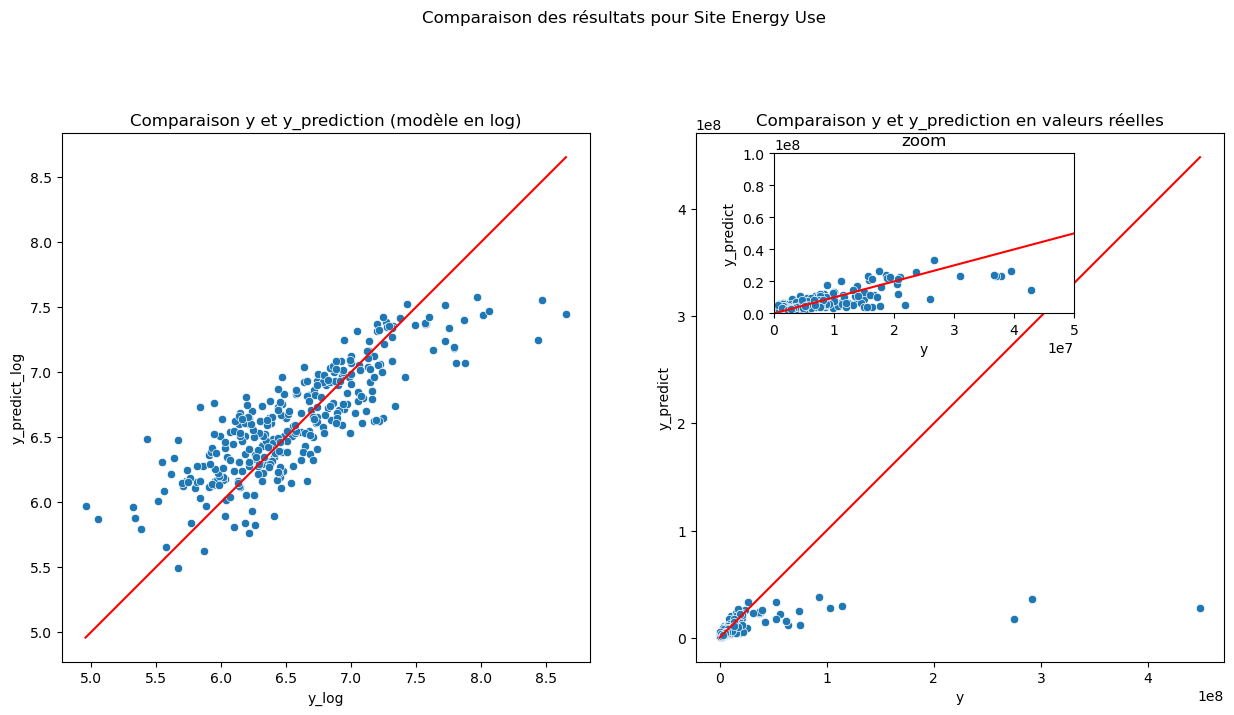

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8), sharey=False)

X_plot = [prediction_energy['y_log'].min(), prediction_energy['y_log'].max()]
sns.lineplot(X_plot, X_plot,color = "red", ax= ax1)
sns.scatterplot(x = prediction_energy['y_log'],
               y = prediction_energy['y_predict_log'],
               ax = ax1)

X_plot = [prediction_energy['y'].min(), prediction_energy['y'].max()]
sns.lineplot(X_plot, X_plot,color = "red", ax= ax2)
sns.scatterplot(x = prediction_energy['y'],
               y = prediction_energy['y_predict'],
               ax=ax2)

ax3 = plt.axes([0.6, 0.6, .2, .2])
X_plot = [prediction_energy['y'].min(), prediction_energy['y'].max()]
sns.lineplot(X_plot, X_plot,color = "red", ax= ax3)
sns.scatterplot(x = prediction_energy['y'],
               y = prediction_energy['y_predict'], ax=ax3)
ax3.set_title('zoom')
ax3.set_xlim([0.0,0.5*1e8])
ax3.set_ylim([0.0,1*1e8])

ax1.set_aspect('equal', 'box')

ax2.set_aspect('equal', 'box')

ax1.title.set_text('Comparaison y et y_prediction (modèle en log)')
ax2.title.set_text('Comparaison y et y_prediction en valeurs réelles')
fig.suptitle('Comparaison des résultats pour Site Energy Use')

In [91]:
rf_co2_optimal = rf_co2_grid.best_estimator_

In [92]:
y_co2_pred = rf_co2_optimal.predict(X_Co2_test)
prediction_co2 = pd.DataFrame([y_Co2_test,pd.Series(y_co2_pred, index = y_Co2_test.index),
                              (10**y_Co2_test)-1,
                               (10**pd.Series(y_co2_pred, index = y_Co2_test.index))-1]).T
prediction_co2.columns = ["y_log","y_predict_log", "y", "y_predict"]

In [93]:
prediction_co2

,y_log,y_predict_log,y,y_predict
135,2.492201,2.363417,309.60,229.896235
1427,1.009876,1.502931,9.23,30.836891
829,2.258589,2.223204,180.38,166.187644
999,1.498173,1.793411,30.49,61.145714
809,0.928908,0.999233,7.49,8.982364
...,...,...,...,...
286,2.305674,2.407757,201.15,254.715751
506,2.195180,1.938353,155.74,85.766599
1299,1.551694,2.003802,34.62,99.879182
514,1.943989,1.649755,86.90,43.643189


Text(0.5, 0.98, 'Comparaison des résultats pour CO2')

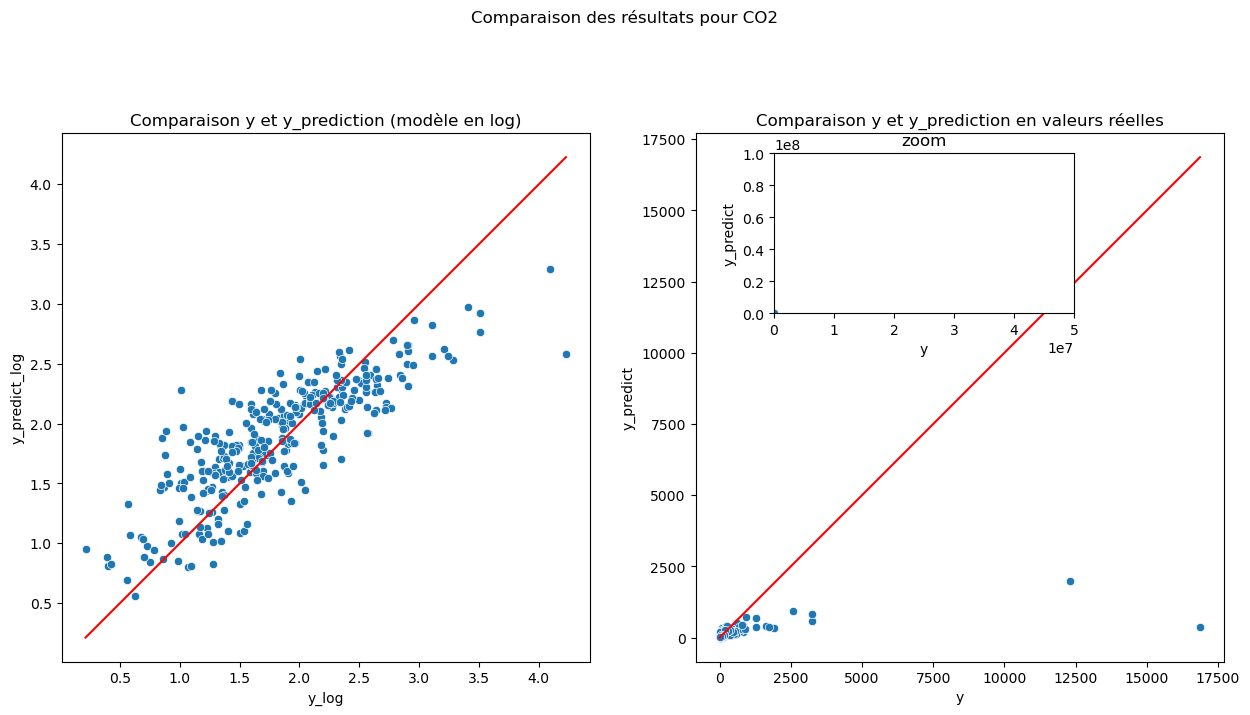

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8), sharey=False)

X_plot = [prediction_co2['y_log'].min(), prediction_co2['y_log'].max()]
sns.lineplot(X_plot, X_plot,color = "red", ax= ax1)
sns.scatterplot(x = prediction_co2['y_log'],
               y = prediction_co2['y_predict_log'],
               ax = ax1)

X_plot = [prediction_co2['y'].min(), prediction_co2['y'].max()]
sns.lineplot(X_plot, X_plot,color = "red", ax= ax2)
sns.scatterplot(x = prediction_co2['y'],
               y = prediction_co2['y_predict'],
               ax=ax2)

ax3 = plt.axes([0.6, 0.6, .2, .2])
X_plot = [prediction_co2['y'].min(), prediction_co2['y'].max()]
sns.lineplot(X_plot, X_plot,color = "red", ax= ax3)
sns.scatterplot(x = prediction_co2['y'],
               y = prediction_co2['y_predict'], ax=ax3)
ax3.set_title('zoom')
ax3.set_xlim([0.0,0.5*1e8])
ax3.set_ylim([0.0,1*1e8])

ax1.set_aspect('equal', 'box')

ax2.set_aspect('equal', 'box')

ax1.title.set_text('Comparaison y et y_prediction (modèle en log)')
ax2.title.set_text('Comparaison y et y_prediction en valeurs réelles')
fig.suptitle('Comparaison des résultats pour CO2')

## Intéret de EnergyStarScore :

In [104]:
encoder_ES = TargetEncoder()
scaler_ES = RobustScaler()

In [105]:
numerical_ES

['ENERGYSTARScore',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'BuildingAge',
 'ParkingRatio',
 'BuildingRatio',
 'FloorsRatio',
 'BuildingsRatio',
 'LargestUseTypeRatio',
 'SecondLargestUseTypeRatio',
 'ThirdLargestUseTypeRatio',
 'NumberOfAllUseTypes',
 'distance_from_center']

In [106]:
categorical_ES

['PrimaryPropertyType',
 'Neighborhood',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType']

In [121]:
X_energy_ES_train

,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),BuildingAge,ParkingRatio,BuildingRatio,FloorsRatio,BuildingsRatio,LargestUseTypeRatio,SecondLargestUseTypeRatio,ThirdLargestUseTypeRatio,NumberOfAllUseTypes,distance_from_center
218,Large Office,DOWNTOWN,Office,Other,Data Center,69.0,0,1,1,22,0.0000,1.0000,22177.8571,310490.0,0.8673,0.0914,0.0019,26,0.305526
1604,Hotel,LAKE UNION,Hotel,Parking,Swimming Pool,72.0,0,1,1,9,0.3275,0.6725,31705.7500,126823.0,0.6951,0.3275,0.0000,29,5.520323
286,Retail Store,DOWNTOWN,Retail Store,Other,nouse,71.0,1,1,1,94,0.0000,1.0000,107712.7500,861702.0,0.5911,0.4417,0.0000,19,0.703611
432,Small- and Mid-Sized Office,DOWNTOWN,Office,Retail Store,nouse,87.0,1,1,1,123,0.0000,1.0000,17454.2500,69817.0,0.4963,0.3730,0.0000,20,0.725424
1307,Large Office,DOWNTOWN,Office,Parking,Multifamily Housing,71.0,0,1,0,40,0.2701,0.7299,23658.2308,307557.0,0.5281,0.2701,0.1790,50,0.490438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,Self-Storage Facility,NORTHEAST,Self-Storage Facility,nouse,nouse,71.0,0,1,1,17,0.1480,0.8520,8029.8333,48179.0,1.0000,0.0000,0.0000,21,9.880776
1294,Worship Facility,EAST,Worship Facility,nouse,nouse,91.0,0,1,1,117,0.0000,1.0000,26440.0000,26440.0,1.0000,0.0000,0.0000,16,2.094915
860,Warehouse,BALLARD,Non-Refrigerated Warehouse,nouse,nouse,63.0,0,1,1,73,0.0000,1.0000,27553.0000,27553.0,1.0000,0.0000,0.0000,26,6.462937
1459,Mixed Use Property,EAST,Other - Entertainment/Public Assembly,Other - Public Services,Restaurant,71.0,0,1,1,76,0.0000,1.0000,10828.0000,21656.0,0.2612,0.2568,0.2350,119,2.260649


In [ ]:
X_energy_ES_train, X_energy_ES_test, y_energy_ES_train, y_energy_ES_test

In [ ]:
X_Co2_ES_train, X_Co2_ES_test, y_Co2_ES_train, y_Co2_ES_test

In [122]:
X_energy_ES_train[categorical_ES]= encoder_ES.fit_transform(X_energy_ES_train[categorical_ES], y_energy_ES_train)
X_energy_ES_test[categorical_ES]= encoder_ES.transform(X_energy_ES_test[categorical_ES], y_energy_ES_test)


X_Co2_ES_train[categorical_ES]=encoder_ES.fit_transform(X_Co2_ES_train[categorical_ES], y_Co2_ES_train)
X_Co2_ES_test[categorical_ES]=encoder_ES.transform(X_Co2_ES_test[categorical_ES], y_Co2_ES_test)

In [128]:
X_energy_ES_train

,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),BuildingAge,ParkingRatio,BuildingRatio,FloorsRatio,BuildingsRatio,LargestUseTypeRatio,SecondLargestUseTypeRatio,ThirdLargestUseTypeRatio,NumberOfAllUseTypes,distance_from_center
218,7.119745,6.736669,6.587316,6.427506,6.631182,-0.10,0.0,0.0,0.0,-0.618026,0.0000,0.0000,-0.025153,3.723415,-0.327934,0.389599,0.0019,0.30,-0.603504
1604,6.876287,6.653944,6.877914,6.813752,6.595044,0.05,0.0,0.0,0.0,-0.841202,0.3275,-0.3275,0.360063,1.123179,-0.894334,1.395993,0.0000,0.45,0.338551
286,6.446237,6.736669,6.440975,6.427506,6.434230,0.00,1.0,0.0,0.0,0.618026,0.0000,0.0000,3.433054,11.527110,-1.236411,1.882779,0.0000,-0.05,-0.531590
432,6.307746,6.736669,6.587316,6.413230,6.434230,0.80,1.0,0.0,0.0,1.115880,0.0000,0.0000,-0.216131,0.316126,-1.548228,1.589940,0.0000,0.00,-0.527650
1307,7.119745,6.736669,6.587316,6.813752,6.522156,0.00,0.0,0.0,-1.0,-0.309013,0.2701,-0.2701,0.034699,3.681892,-1.443631,1.151321,0.1790,1.50,-0.570100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,6.013759,6.553005,6.013759,6.366559,6.434230,0.00,0.0,0.0,0.0,-0.703863,0.1480,-0.1480,-0.597163,0.009790,0.108544,0.000000,0.0000,0.05,1.126269
1294,5.990063,6.552712,5.990063,6.366559,6.434230,1.00,0.0,0.0,0.0,1.012876,0.0000,0.0000,0.147167,-0.297977,0.108544,0.000000,0.0000,-0.20,-0.280250
860,6.052725,6.262544,6.067447,6.366559,6.434230,-0.40,0.0,0.0,0.0,0.257511,0.0000,0.0000,0.192166,-0.282219,0.108544,0.000000,0.0000,0.30,0.508835
1459,6.472017,6.552712,6.539613,6.447536,6.675845,0.00,0.0,0.0,0.0,0.309013,0.0000,0.0000,-0.484032,-0.365705,-2.321520,1.094629,0.2350,4.95,-0.250310


In [126]:
X_energy_ES_train[numerical_ES]= scaler_ES.fit_transform(X_energy_ES_train[numerical_ES])
X_energy_ES_test[numerical_ES]= scaler_ES.transform(X_energy_ES_test[numerical_ES])


X_Co2_ES_train[numerical_ES]=scaler_ES.fit_transform(X_Co2_ES_train[numerical_ES])
X_Co2_ES_test[numerical_ES]=scaler_ES.transform(X_Co2_ES_test[numerical_ES])

In [127]:
X_energy_ES_train

,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),BuildingAge,ParkingRatio,BuildingRatio,FloorsRatio,BuildingsRatio,LargestUseTypeRatio,SecondLargestUseTypeRatio,ThirdLargestUseTypeRatio,NumberOfAllUseTypes,distance_from_center
218,7.119745,6.736669,6.587316,6.427506,6.631182,-0.10,0.0,0.0,0.0,-0.618026,0.0000,0.0000,-0.025153,3.723415,-0.327934,0.389599,0.0019,0.30,-0.603504
1604,6.876287,6.653944,6.877914,6.813752,6.595044,0.05,0.0,0.0,0.0,-0.841202,0.3275,-0.3275,0.360063,1.123179,-0.894334,1.395993,0.0000,0.45,0.338551
286,6.446237,6.736669,6.440975,6.427506,6.434230,0.00,1.0,0.0,0.0,0.618026,0.0000,0.0000,3.433054,11.527110,-1.236411,1.882779,0.0000,-0.05,-0.531590
432,6.307746,6.736669,6.587316,6.413230,6.434230,0.80,1.0,0.0,0.0,1.115880,0.0000,0.0000,-0.216131,0.316126,-1.548228,1.589940,0.0000,0.00,-0.527650
1307,7.119745,6.736669,6.587316,6.813752,6.522156,0.00,0.0,0.0,-1.0,-0.309013,0.2701,-0.2701,0.034699,3.681892,-1.443631,1.151321,0.1790,1.50,-0.570100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,6.013759,6.553005,6.013759,6.366559,6.434230,0.00,0.0,0.0,0.0,-0.703863,0.1480,-0.1480,-0.597163,0.009790,0.108544,0.000000,0.0000,0.05,1.126269
1294,5.990063,6.552712,5.990063,6.366559,6.434230,1.00,0.0,0.0,0.0,1.012876,0.0000,0.0000,0.147167,-0.297977,0.108544,0.000000,0.0000,-0.20,-0.280250
860,6.052725,6.262544,6.067447,6.366559,6.434230,-0.40,0.0,0.0,0.0,0.257511,0.0000,0.0000,0.192166,-0.282219,0.108544,0.000000,0.0000,0.30,0.508835
1459,6.472017,6.552712,6.539613,6.447536,6.675845,0.00,0.0,0.0,0.0,0.309013,0.0000,0.0000,-0.484032,-0.365705,-2.321520,1.094629,0.2350,4.95,-0.250310


### Entrainement et cross validation

## CO2

In [129]:
rf_co2_ES = gridCV(RandomForestRegressor(), random_parameters, X_Co2_ES_train, y_Co2_ES_train,5)

Execution time for gridCV: 1385.7438578605652s


In [160]:
rf_res_ES_Co2 = resultats_grid(rf_co2_ES, "RF_ES_Co2",X_Co2_ES_train, y_Co2_ES_train)
rf_res_ES_Co2

Execution time for resultats_grid: 0.03326272964477539s


,modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
0,RF_ES_Co2,0.40741,0.009819,0.239156,0.350603,"{'bootstrap': True, 'max_depth': 20, 'max_feat...",0.15271


In [150]:
rf_res_co2

,modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
0,RandomForest,0.380921,0.009713,0.247432,0.3629,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.228975


In [153]:
best_rf_model = rf_co2_ES.best_estimator_
importances = feature_importance(best_rf_model, X_Co2_ES_train.columns)
print(importances)

                         feature  importance
13                BuildingsRatio    0.342585
8               NaturalGas(kBtu)    0.178387
0            PrimaryPropertyType    0.108655
2         LargestPropertyUseType    0.100536
12                   FloorsRatio    0.052134
5                ENERGYSTARScore    0.043086
6                 SteamUse(kBtu)    0.038956
9                    BuildingAge    0.026568
18          distance_from_center    0.021750
14           LargestUseTypeRatio    0.020858
17           NumberOfAllUseTypes    0.016422
1                   Neighborhood    0.012140
15     SecondLargestUseTypeRatio    0.010802
3   SecondLargestPropertyUseType    0.007594
10                  ParkingRatio    0.006753
11                 BuildingRatio    0.005300
16      ThirdLargestUseTypeRatio    0.004097
4    ThirdLargestPropertyUseType    0.003375
7              Electricity(kBtu)    0.000000


## Energy

In [161]:
rf_energy_ES = gridCV(RandomForestRegressor(), random_parameters, X_energy_ES_train, y_energy_ES_train,5)

Execution time for gridCV: 1362.5463190078735s


In [162]:
rf_res_ES_energy = resultats_grid(rf_energy_ES, "RF_ES_Co2",X_energy_ES_train, y_energy_ES_train)
rf_res_ES_energy

Execution time for resultats_grid: 0.037671804428100586s


,modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
0,RF_ES_Co2,0.400789,0.009593,0.204059,0.300674,"{'bootstrap': False, 'max_depth': 40, 'max_fea...",0.104818


In [163]:
rf_res_energy

,modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
0,RandomForest,0.393424,0.010089,0.218423,0.320703,"{'bootstrap': False, 'max_depth': 20, 'max_fea...",0.117606


In [164]:
best_rf_model = rf_energy_ES.best_estimator_
importances = feature_importance(best_rf_model, X_Co2_ES_train.columns)
print(importances)

                         feature  importance
13                BuildingsRatio    0.410125
0            PrimaryPropertyType    0.180306
2         LargestPropertyUseType    0.118824
12                   FloorsRatio    0.086274
5                ENERGYSTARScore    0.055517
8               NaturalGas(kBtu)    0.022787
18          distance_from_center    0.020364
14           LargestUseTypeRatio    0.018409
9                    BuildingAge    0.016761
3   SecondLargestPropertyUseType    0.014698
17           NumberOfAllUseTypes    0.014340
15     SecondLargestUseTypeRatio    0.011382
1                   Neighborhood    0.009305
11                 BuildingRatio    0.005554
10                  ParkingRatio    0.005045
16      ThirdLargestUseTypeRatio    0.004300
4    ThirdLargestPropertyUseType    0.004193
6                 SteamUse(kBtu)    0.001815
7              Electricity(kBtu)    0.000000


Le score pour la consommation d'énergie s'est amélioré.

Le score pour les émissions de Co2 s'est  amélioré.